<a href="https://colab.research.google.com/github/LucianoPer/VPC2/blob/main/9_Clasificacion_Deteccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Localizacion, Clasificacion y Deteccion de objetos 

Las tareas de localizacion y clasificacion generalmente se refieren a un solo objeto, cuando hablamos de deteccion podemos referirnos a multiples objetos de diferentes categorias.

Datasets para deteccion de objetos:

● PASCAL VOC Dataset:
http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html

● COCO Dataset (Common Objects in COntext), https://cocodataset.org

### **Localizacion**

Tenemos un clasificador entrenado para detectar un objeto especifico, lo que necesitamos ahora, es localizar el objeto a clasificar dentro de una imagen . Para realizar esta tarea encontramos diferentes algoritmos:

### **Algoritmo de sliding windows:**

En este algoritmo nos apoyamos sobre un clasificador existente, como desventaja tiene gran costo computacional y no es muy preciso ya que desplaza la ventana fija (bounding box) por lugares establecidos de la imagen.


Mejoras: Al realizar los calculos de la red convolucional con la bounding box, muchos de esos pixeles se vuelven a repetir al desplazar la ventana, ya que estamos tomando gran parte de la ventana anterior. Por lo tanto podemos reutilizar los calculos realizados con anterioridad y optimizar el costo computacional. 

Reemplazamos los layers Fully-conected por convoluciones de 1x1 por la cantidad de neuronas que teniamos en la FC, son totalmente equivalentes entre si. 

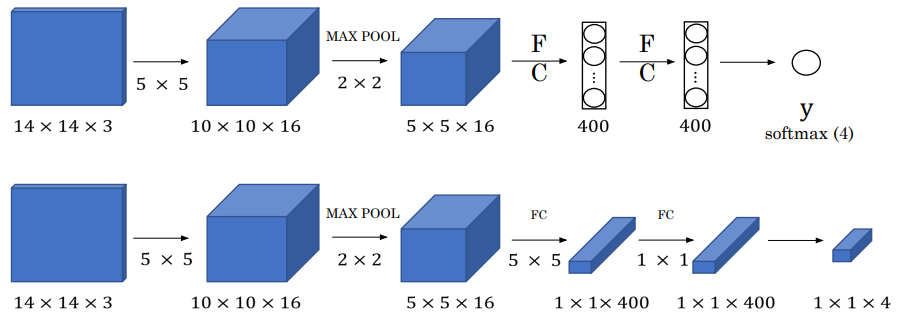

Por lo tanto ahora tenemos una red convolucional que nos ayuda a localizar y clasificar un objeto. Esta red tiene mucho costo computacional y no es muy precisa ya que puede ocurrir que ninguna bounding box se acopie bien al objeto.

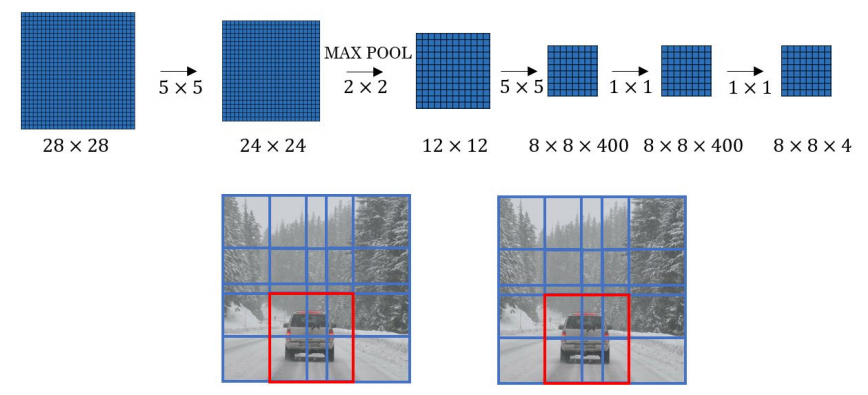

### **Performance de los algoritmos de localizacion y clasificacion**

Para poder medir la performance de nuestros modelos necesitamos una metrica que se adapte a la tarea que estamos realizando. 
- mAP: mean Average Precision para detección de objetos

Para esto necesitamos que el algoritmo encuentre el objeto (bounding box) y lo clasifique. La salida sera los bloques o bounding box con la probabilidad de que corresponda a un objeto. 

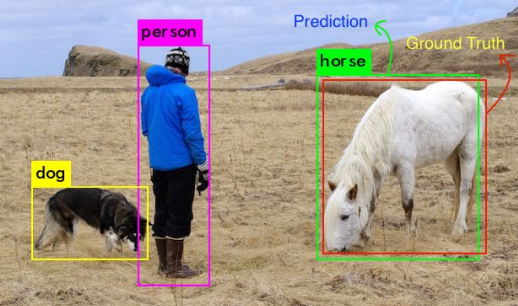

Se compara la prediccion con la Ground Truth mediante el metodo de Jaccard Index o interseccion/Union para determinar cuan bueno es nuestro modelo.
Se calcula el area de la interseccion y se divide por el area de la union. 

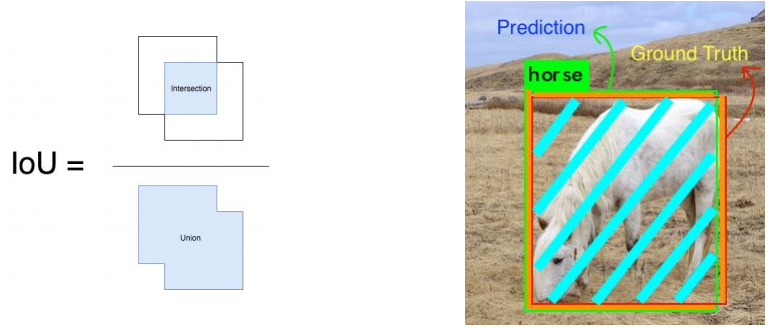

Los modelos retornan para cada imagen una lista de : Una bounding box con una clase predicha y un nivel de confianza. 

● Las predicciones son asociadas a un objeto del ground truth si IoU > 0.5 (para Pascal VOC es 0.5, para COCO se usan una serie de niveles de IoU de corte)

● Múltiples detecciones de un objeto son ranqueadas según el nivel de confianza asignado.

● Si hay varias predicciones para un objeto sólo una se considera correcta, las demás incorrectas (el algoritmo debería descartar múltiples detecciones)

● Para cada clase del dataset se calcula la curva de precision/recall, que especifica el nivel de precisión (definida como proporción de los ejemplos por encima de un rango que pertenecen a la clase correcta) para un dado recall (proporción de los ejemplos positivos que aparecen por encima de un cierto rango)

● Average precision resume la forma de la curva de precision/recall, y es definido como la precision media en un conjunto de 11 niveles de recall equiespaciados: [0,0.1,...,1] (en Pascal VOC)

● Sirve para medir a nivel de dataset entero no en imagenes individuales

● Es una medida que se evalúa por cada clase a clasificar, o sea, debe medirse a nivel del dataset.

● Es bastante buena para comparar métodos diferentes

### **Ejemplo**

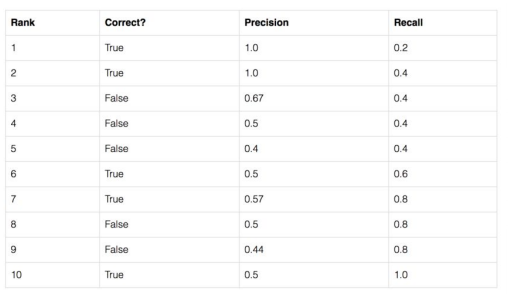

La tabla corresponde a un dataset que contiene 5 objetos del mismo tipo. 
En el primer caso podemos ver que el algoritmo localizo bien el objeto (Precision = 1), es decir, trazo las bounding box donde estaba el objeto. Pero solo localizo el 20% es decir un solo objeto. En el segundo caso encontro 2 y trazo la bounding box en los lugares correctos. Con estos datos podemos realizar la grafica Presicion/Recall 

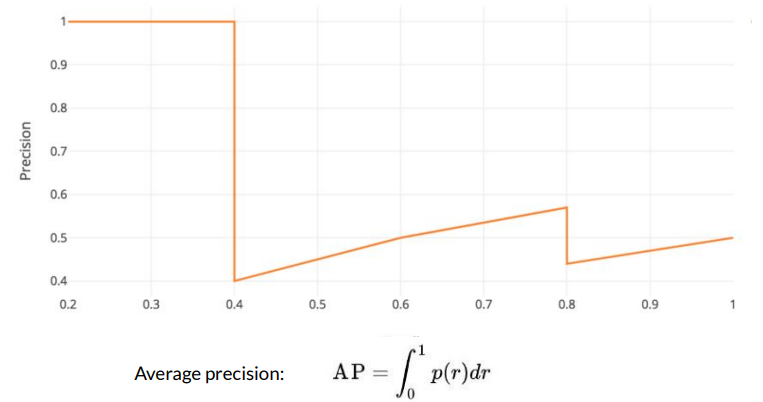

Para un algoritmo perfecto la linea continuaria en 1 y el area bajo la curva seria maxima. Es decir, para todos los niveles de Recall la precision seria 1.

### **Algoritmos de Deteccion**

● **Métodos de dos etapas:**

  ○ R-CNN (region proposals CNN)

  ○ Fast R-CNN

  ○ Faster R-CNN

  ○ Otros

● **Métodos de una etapa:**

  ○ YOLO (You Only Look Once)

  ○ Otros: RetinaNet, SSD (Single-shot detection)


## **R-CNN** : Regions with CNN features

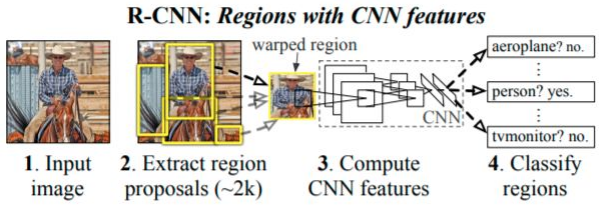

**● Primera etapa: búsqueda selectiva (selective search)**

○ Se genera una sub-segmentación inicial, se generan muchas regiones candidatas

○ Se usa un algoritmo greedy para combinar recursivamente regiones similares en regiones mayores

○ Se usan las regiones generadas para producir las propuestas de regiones candidatas (region proposals), alrededor de 2000 por imagen.


**● Segunda etapa:**

○ Cada una de las regiones es pasada por una red convolucional que extrae features

○ En la capa final se utiliza una Support Vector Machine para clasificar cada región propuesta y
asignarle un nivel de confianza a cada región

○ Se utiliza non-max suppression para cada clase para determinar las regiones que sobreviven. Basandonos en los valores de Iou se eliminan las cajas superpuestas de la misma clase. No descarta si pertenece a una clase diferente  o si esta por debajo del umbral de Iou de superposicion. 


## **YOLO** : 

● Algoritmo de una sola etapa

● Muy veloz

● Varias versiones


Este algoritmo realiza la localizacion y la clasificacion en una sola etapa. 

La salida tendra la primer componente si hay o no objeto, la segunda componente devuelve el centro del objeto, luego en las proximas dos devuelve el ancho y alto en proporcion al tamano de la imagen, y por ultimo las probabilidades de que sea cada objeto de las clases del dataset. Ejemplo:

```
[[1]          [[hay objeto]
 [0.4]         [centro x]
 [0.5]         [centro y]
 [0.3]         [tam. x]
 [0.2]         [tam. y]
 [1]           [prob 1]
 [0]           [prob 2]
 [0]]          [prob 3]]

```



### Funcion de Perdida

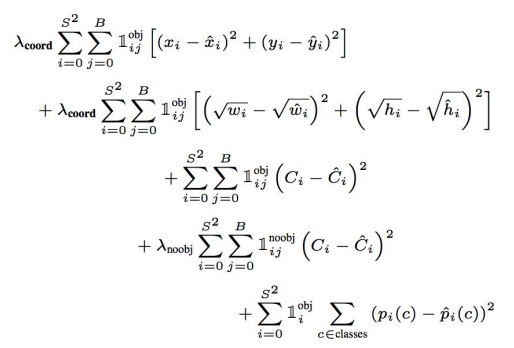

El primer termino dentro de la sumatoria es (1obj) indica con 1 si esta el objeto y con 0 si no esta el objeto. Luego el termino siguiente es el centro real del objeto y el centro dado por la prediccion. En la proxima sumatoria tenemos lo mismo pero con el ancho y el alto del objeto. Luego considera si hay objeto de una clase y tambien si no lo hay, en este ultimo tiene un factor lamda para penalizar y aumentar el peso dentro de la funcion de perdida. Por ultimo consideramos las probabilidades de las clases reales y las predichas. 

Cuando no hay objeto los primeros factores desaparecen pero sobrevive el que contiene (noobj) 

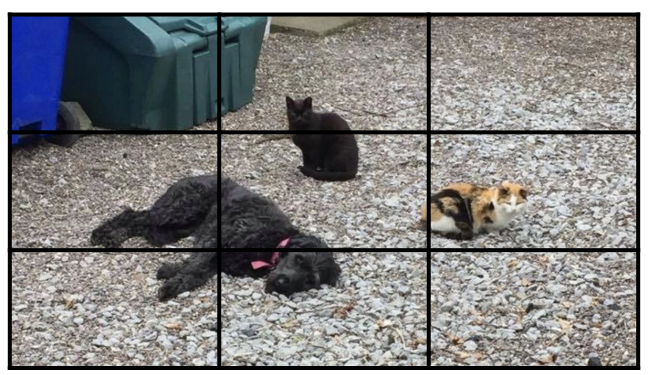

El algoritmo de YOLO parte el la imagen en una grilla y en cada celda calcula el vector comentado con anterioridad indicando si esta el objeto su centro, el tamano y las probabilidades. Los objetos se asignan a la celda , pero solo aquellas celdas donde se encuentre el centro del objeto. La salida del algoritmo dara 9 vectores correspondiente a cada celda.

La salida del algoritmo tendra:

$n=celdas_w*celdas_h*Anchor*(1+4+n_{clases})$

Para el ejemplo anterior suponiendo 2 clases:

$n=celdas_w*celdas_h**Anchor*(1+4+n_{clases}) = 3*3*1(1+4+2) = 3x3x(1x7)$

A diferencia de Sliding Windows, YOLO permite una bounding box mucho mas precisa . 

Luego de realizar el dataset se realiza la red convolucional para entrenar y predecir las clases. 

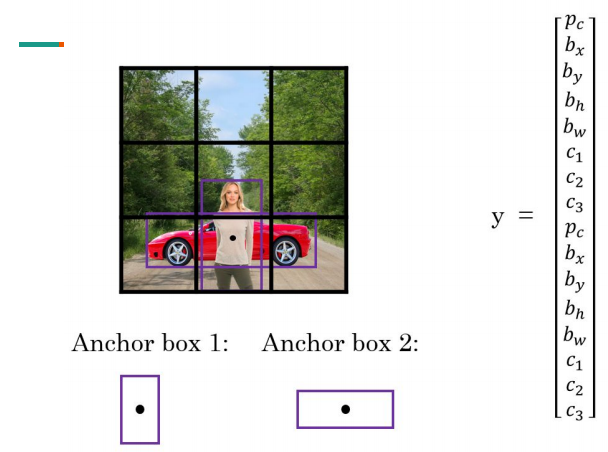

Cuando hay mas de un objeto dentro de las celdas la salida contiene dos vectores correspondientes a cada anchorBox. Cada AnchorBox fue seleccionado segun los valores de Iou, quedandose con el que le dio mas alto con cada objeto. 

### Primera version de YOLO : grilla de 7x7 - 20 clases

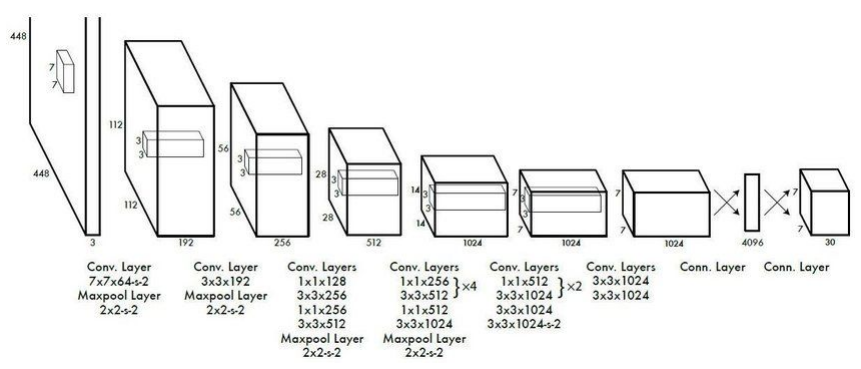

**Limitaciones de YOLO:**
- Sin las anchor boxes solo puede reconocer un solo objeto por grilla, por este motivo es que luego se agregan los anchor-boxes.

- El maximo numero de objetos a reconocer es por lo tanto 7x7x1 = 49 objetos

- Tiene un error alto de localizacion

**Mejoras- YOLO V2:**

- Batch Normalization

- Clasificador de mayor resolución: el tamaño de la entrada fue aumentado de 224x224 a 448x448 (en un paso de tuning del entrenamiento)

- Anchor boxes: permiten detectar varios objetos en la misma celda. Se eligen utilizando un algoritmo de k-means clustering

- se aumenta la grilla a 13x13, lo que permite identificar y localizar objetos más pequeños 

- entrenamiento multi-escala: si YOLO es entrenado con imágenes pequeñas de un objeto tiene dificultad de detectarlo cuando el objeto aparece más grande en la imagen. Para eso se entrena con imágenes aleatorias con diferentes dimensiones. Como el modelo sólo tiene capas convolucionales y de pooling la entrada puede ser redimensionada ‘on the fly’. Como resultado la red es más robusta para detectar objetos en diferentes resoluciones

- Darknet 19: Utiliza la arquitectura Darknet 19 con 19 capas convolucionales, 5 max pool y softmax para clasificación. La arquitectura es muy veloz.

Implementacion:

In [ ]:
# Verificar que GPU está activada
#!nvidia-smi

In [ ]:
#import tensorflow as tf
#print(tf.__version__)
#tf.test.gpu_device_name()

In [ ]:
!git clone https://github.com/pythonlessons/TensorFlow-2.x-YOLOv3.git

Cloning into 'TensorFlow-2.x-YOLOv3'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 740 (delta 1), reused 2 (delta 0), pack-reused 733
Receiving objects: 100% (740/740), 70.76 MiB | 30.09 MiB/s, done.
Resolving deltas: 100% (433/433), done.


In [ ]:
%cd TensorFlow-2.x-YOLOv3

/content/TensorFlow-2.x-YOLOv3


In [ ]:
!pip install -r ./requirements.txt

     |████████████████████████████████| 320.4MB 51kB/s 
     |████████████████████████████████| 320.4MB 56kB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 3.5MB 57.5MB/s 
     |████████████████████████████████| 81kB 13.6MB/s 
     |████████████████████████████████| 7.1MB 52.0MB/s 
     |████████████████████████████████| 552kB 54.2MB/s 
     |████████████████████████████████| 71kB 11.7MB/s 
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=c2fd4415f88a4e89b97ae1c9a06d7758b38fa7afdf20b490391966f789fc5c86
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: botocore 1.19.34 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.
  Found existing installation:

In [ ]:
!wget -P model_data https://pjreddie.com/media/files/yolov3.weights

--2020-12-11 18:48:40--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘model_data/yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   957KB/s    in 4m 22s  

2020-12-11 18:53:03 (925 KB/s) - ‘model_data/yolov3.weights’ saved [248007048/248007048]



In [ ]:

import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import tensorflow as tf
from yolov3.yolov4 import Create_Yolo
from yolov3.utils import load_yolo_weights, detect_image
from yolov3.configs import *

In [ ]:
if YOLO_TYPE == "yolov4":
    Darknet_weights = YOLO_V4_TINY_WEIGHTS if TRAIN_YOLO_TINY else YOLO_V4_WEIGHTS
if YOLO_TYPE == "yolov3":
    Darknet_weights = YOLO_V3_TINY_WEIGHTS if TRAIN_YOLO_TINY else YOLO_V3_WEIGHTS

yolo = Create_Yolo(input_size=YOLO_INPUT_SIZE)
load_yolo_weights(yolo, Darknet_weights) # use Darknet weights

In [ ]:
!wget https://www.buenosaires.gob.ar/sites/gcaba/files/img_8008.jpg

--2020-12-11 18:53:34--  https://www.buenosaires.gob.ar/sites/gcaba/files/img_8008.jpg
Resolving www.buenosaires.gob.ar (www.buenosaires.gob.ar)... 200.16.89.104
Connecting to www.buenosaires.gob.ar (www.buenosaires.gob.ar)|200.16.89.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1112037 (1.1M) [image/jpeg]
Saving to: ‘img_8008.jpg’

img_8008.jpg        100%[===================>]   1.06M   453KB/s    in 2.4s    

2020-12-11 18:53:38 (453 KB/s) - ‘img_8008.jpg’ saved [1112037/1112037]



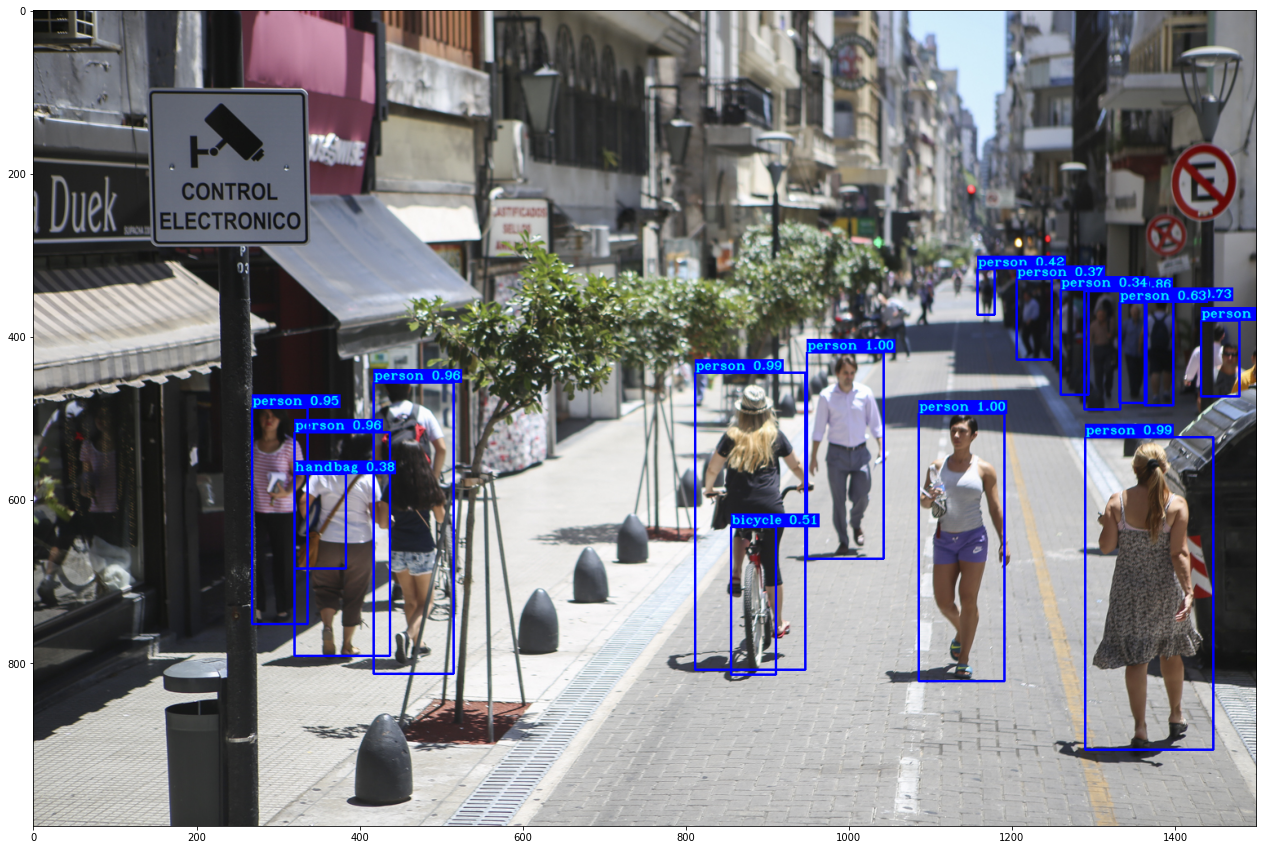

In [ ]:
image_path   = "img_8008.jpg"

image = detect_image(yolo, image_path, '', input_size=YOLO_INPUT_SIZE, show=False, rectangle_colors=(255,0,0))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30,15))
plt.imshow(image)

In [ ]:
!wget https://visionliberal.com.ar/wp-content/uploads/2020/04/londres.jpg

--2020-12-11 18:57:31--  https://visionliberal.com.ar/wp-content/uploads/2020/04/londres.jpg
Resolving visionliberal.com.ar (visionliberal.com.ar)... 200.58.111.39, 2800:6c0:2::8c
Connecting to visionliberal.com.ar (visionliberal.com.ar)|200.58.111.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 745022 (728K) [image/jpeg]
Saving to: ‘londres.jpg’

londres.jpg         100%[===================>] 727.56K   229KB/s    in 3.2s    

2020-12-11 18:57:35 (229 KB/s) - ‘londres.jpg’ saved [745022/745022]



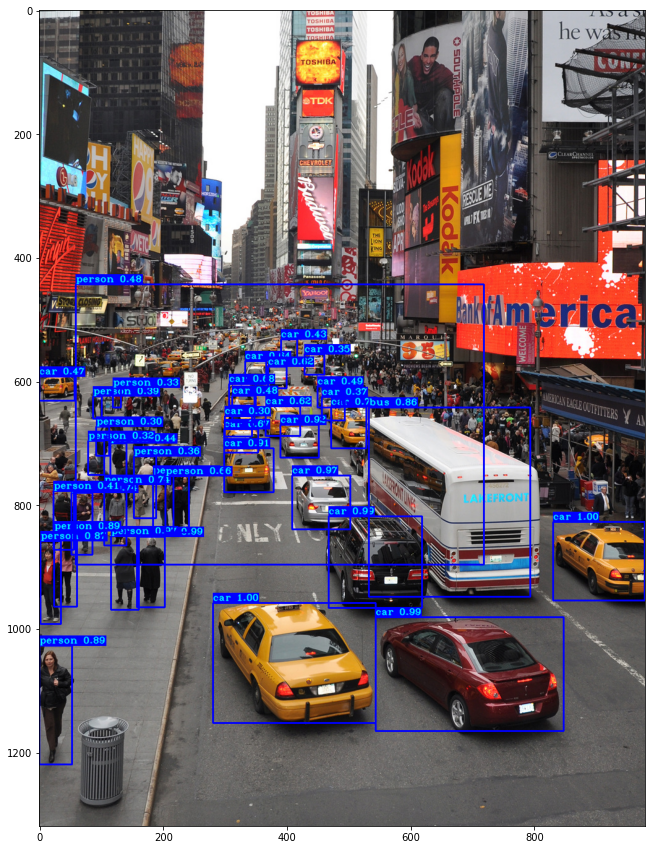

In [ ]:
image_path   = "londres.jpg"

image = detect_image(yolo, image_path, '', input_size=YOLO_INPUT_SIZE, show=False, rectangle_colors=(255,0,0))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30,15))
plt.imshow(image)

Enlaces:

yolo v4: https://github.com/emadboctorx/yolo-tf2

yolo v3: https://github.com/zzh8829/yolov3-tf2